In [1]:
# code all of the components of a simple CNN for image recognition on CIFAR
# import everything (recommendation)
import torch
import torchvision
import torchvision.transforms as transforms

Preparing data

In [2]:
# data preprocessing and processing
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])


# number of images/iter, computational cost (VRAM & GPU utilization)
# GPUs make better use of parallelization (processing multiple images faster
# than processing images sequentially 1 by 1)
# throughput (how many images can we process in a second: 0.5 imgs / s)
# latency (how many seconds does it take to process an image: 2 s / img)
batch_size = 4


trainset = torchvision.datasets.CIFAR10(root='./data/', train=True,
                                        download=True, transform=transform)

# returns at each iteration: batch_size, number_channels, image_width, image_height
# cpu processing (parallel)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=1)


testset = torchvision.datasets.CIFAR10(root='./data/', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=1)

100%|██████████| 170M/170M [00:05<00:00, 34.1MB/s]


Visualizing data

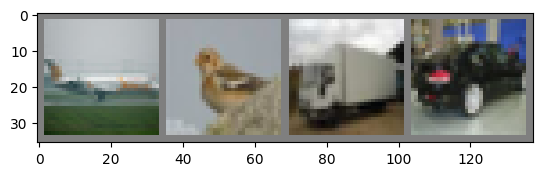

plane bird  truck car  


In [3]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# classes names
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)


# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

Setting up model

In [4]:
import torch.nn as nn
import torch.nn.functional as F

# lenet (1989 yann lecun)
# autograd functionality
# deep learning: tensorflow, pytorch
# sigmoid: 1 / e^-x
# backprop: x * 1/e^-x
# backward()

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        # number_input_channels, # number_output_channels, kernel_size
        self.conv1 = nn.Conv2d(3, 6, 5)
        # kernel_size, stride
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        # b, num_channels, h, w -> b, (num_channels x h x w)
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Assuming that we are on a CUDA machine, this should print a CUDA device:

print(device)

net = Net()
net = net.to(device)


cuda:0


Set up cost function and optimizer

In [5]:
import torch.optim as optim


# computing the difference between the ground truth label (car, 1 0 0) and the prediction (plane, 0.1 0.3. 0.6)
criterion = nn.CrossEntropyLoss()


# taking care of this changing in the parameters P_t-1 -optimizer -> P_t
# P_t = P_t-1 + weight*gradient (how wrong the prediction is)
# move the parameters of the neural network to a local optimum
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)


Train loop

In [6]:
# epoch is going through over all of the items in the dataset
# cifar10: 50k images, bs=4, 50000/4 = 12500 (iterations / epoch)
# decide the number of epochs: the number of images that we will see is epochs * number_images_train_ds
# with cifar 2 epochs: 100k images (network has seen)
# decide the number of steps: bs*1000 = 4*1000 = 4000
# another dataset: 10k images * 2 epochs = 20k images (network has seen)
# 4 * n_iters = 100000 -> n_iters = 100000 / 4 = 25000 iterations
epochs = 2
for epoch in range(epochs):  # loop over the dataset multiple times


    running_loss = 0.0
    for i, data in enumerate(trainloader):
    # i: [0, number_items_iterable] 50k / 4 -> 12500
    # for data in trainloader:
        # get the inputs; data is a list of [inputs, labels]
        # labels: [0, number_classes]
        # images: b, c, h, w pytorch tensors
        # labels: b, pytorch tensors
        # trainloader: c, h, w -> b, c, h, w
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)


        # zero the parameter gradients
        optimizer.zero_grad()


        # forward pass
        outputs = net(inputs)

        # compute cost function
        loss = criterion(outputs, labels)


        # computes gradients in a backpropagation (backward pass)
        loss.backward()
        # updating the parameters with respect to the previous timesteps and the gradients
        optimizer.step()


        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0


print('Finished Training')

[1,  2000] loss: 2.214
[1,  4000] loss: 1.899
[1,  6000] loss: 1.706
[1,  8000] loss: 1.610
[1, 10000] loss: 1.518
[1, 12000] loss: 1.469
[2,  2000] loss: 1.416
[2,  4000] loss: 1.380
[2,  6000] loss: 1.359
[2,  8000] loss: 1.342
[2, 10000] loss: 1.308
[2, 12000] loss: 1.306
Finished Training


Save results

In [7]:
# save results: trained model checkpoint
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

Visualize test data

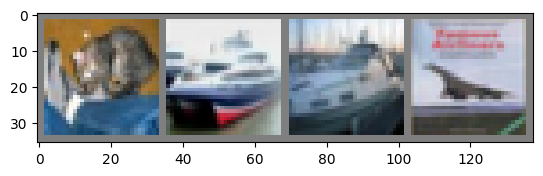

GroundTruth:  cat   ship  ship  plane


In [8]:
# load test data
dataiter = iter(testloader)
images, labels = next(dataiter)


# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))



Make predictions

In [9]:
# forward test images through model
outputs = net(images.to(device))

# get top-1 prediction
_, predicted = torch.max(outputs, 1)

# print inference results
print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(4)))

Predicted:  cat   plane ship  plane


Evaluate on new data

In [10]:
# evaluation / test loop
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest probability is what we choose as prediction
        # plane, car, dog
        # ground truth was 0, 0
        # prediction (0.1 0.3 0.6) (0.5 0.3 0.2) -> 2, 0 -> 50% (correct = 1)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')


Accuracy of the network on the 10000 test images: 54 %
